In [19]:
!pip install easyocr
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
from io import BytesIO
from PIL import Image   # Python Imaging library for load, display, save etc
from google.colab.patches import cv2_imshow
from google.colab import files

Saving CAR4.jpg to CAR4.jpg


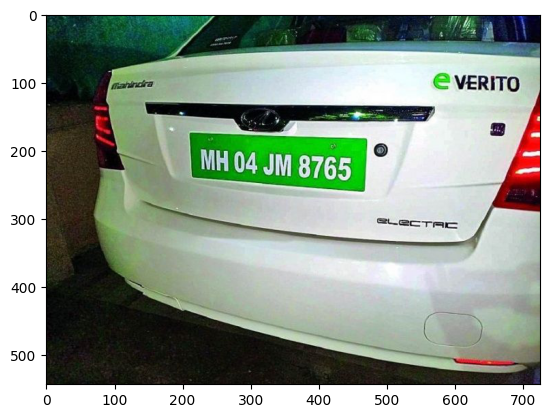

In [21]:
uploaded = files.upload()
filename = next(iter(uploaded))
img1 = Image.open(BytesIO(uploaded[filename]))
img2 = cv2.imread(filename)
plt.imshow(img1)

#gray_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [22]:
gray= cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray_img)

<ipython-input-23-f39eae0a9735>:4: RuntimeWarning: divide by zero encountered in log
  log_transformed = c*np.log(1+gray)


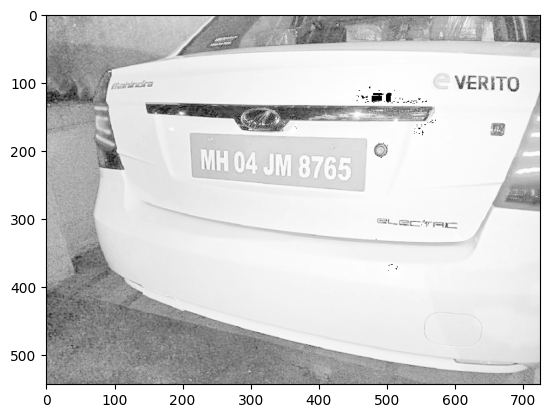

In [23]:
# c = 255/(log(1+m)), m=maximum pixel value
# c = 0.1
c = 255/(np.log(1+np.max(gray)))
log_transformed = c*np.log(1+gray)
log_transformed1 = np.array(log_transformed, dtype = np.uint8)
plt.imshow(log_transformed1, cmap=plt.cm.gray)

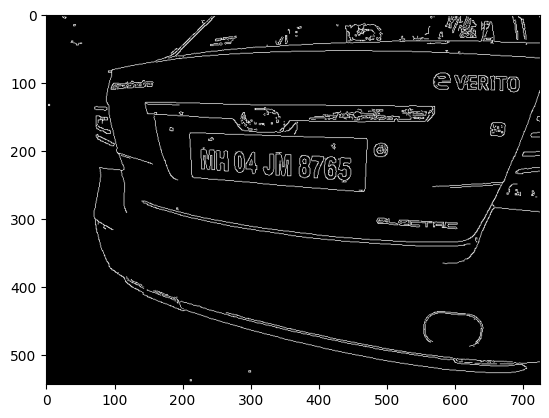

In [24]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [25]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [26]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [27]:
location


array([[[210, 176]],

       [[217, 240]],

       [[468, 256]],

       [[470, 182]]], dtype=int32)

In [28]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img2, img2, mask=mask)

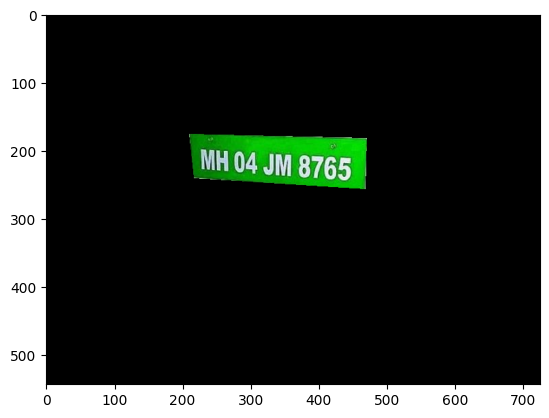

In [29]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [30]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

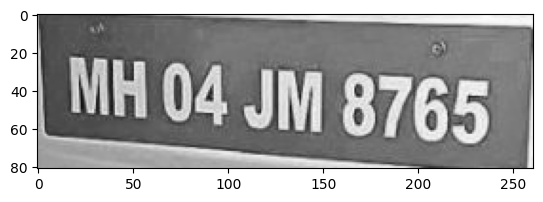

In [31]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [32]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[9, 13], [248, 13], [248, 78], [9, 78]],
  'MH04 JM 8765',
  0.9612722605997128)]

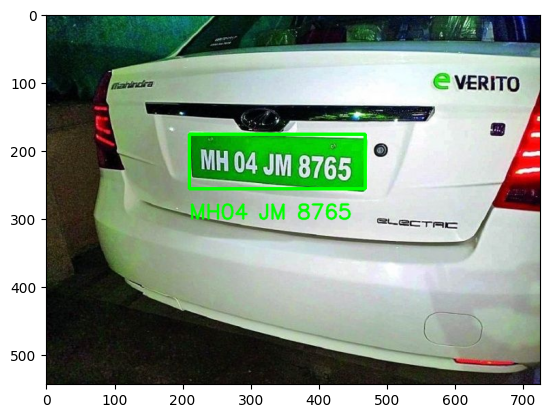

In [33]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img2, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img2, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [34]:
text


'MH04 JM 8765'

In [35]:
import sqlite3
conn=sqlite3.connect("ANPRDATABASE.db")
c3=conn.execute("SELECT * FROM ANPR_TABLE  WHERE License_Number=?",[text])
for itemsl in c3:
    #print(itemsl)
    phone_no= "+91"+itemsl[6]
    print("Name: "+itemsl[0]+"\nLicense Number: "+itemsl[1]+"\nVehicle Number: "+itemsl[2]+"\nVehicle Type: "+itemsl[3]+"\nChasis Number: "+itemsl[4]+"\nPhone Number: "+itemsl[6])

Name: PRITI PAWAR 
License Number: MH04 JM 8765
Vehicle Number: 100523234308
Vehicle Type: MAHINDRA VERTO ELECTRIC
Chasis Number: SADF34839R
Phone Number: 7045479377


In [36]:
import urllib.request
import urllib.parse
 
def sendSMS(apikey, numbers, sender, message):
    data =  urllib.parse.urlencode({'apikey': apikey, 'numbers': numbers,
        'message' : message, 'sender': sender})
    data = data.encode('utf-8')
    request = urllib.request.Request("https://api.textlocal.in/send/?")
    f = urllib.request.urlopen(request, data)
    fr = f.read()
    return(fr)
 
resp =  sendSMS('NDIzMDU2MzA2YTczNTc0OTYxNzY3ODZjNzM3MTYxNzU=', phone_no,
    '600010', 'Hi there, thank you for sending your first test message from Textlocal. See how you can send effective SMS campaigns here: https://tx.gl/r/2nGVj/')
print (resp)

b'{"errors":[{"code":7,"message":"Insufficient credits"}],"status":"failure"}'
